# Load data into Spark DataFrame

In [89]:
from pyspark import SparkContext

In [90]:
import pyspark.sql.functions as F

In [91]:
# We use matplotlib for plotting
import matplotlib.pyplot as plt

# This statement allow to display plot without asking to
%matplotlib inline

In [92]:
df = spark.read.csv('../data/event_ds.csv',header=True).cache()
df

DataFrame[uid: string, event: string, song_id: string, date: string]

In [93]:
df.show()

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168047889|    P|  708741|2017-03-31|
|167704566|    P| 9902748|2017-03-31|
|167630166|    P|  795430|2017-03-31|
|167850949|    P| 6692062|2017-03-31|
|167921394|    P|23485804|2017-03-31|
|167809975|    P|  706163|2017-03-31|
|167639207|    P| 5834967|2017-03-31|
|167921394|    P| 6185714|2017-03-31|
|167890946|    P| 5114569|2017-03-31|
|167662649|    P|22801303|2017-03-31|
|167696423|    P|19247962|2017-03-31|
|167921394|    P|  349914|2017-03-31|
|167809975|    P|  708811|2017-03-31|
| 10199495|    P| 2997638|2017-03-31|
|168047591|    P|  492211|2017-03-31|
|167991657|    P|       0|2017-03-31|
|167864174|    P| 6657692|2017-03-31|
|167809975|    P|  703586|2017-03-31|
|167708087|    P| 2836690|2017-03-31|
|167593391|    P| 7083280|2017-03-31|
+---------+-----+--------+----------+
only showing top 20 rows



In [94]:
# create new or overwrite original field with withColumn
# use withcolumn(a function of spark dataframe) to change type of date
df.withColumn('date',F.col('date').cast('date'))


DataFrame[uid: string, event: string, song_id: string, date: date]

# Some exploration

In [95]:
# simple count rows
df.count()

11732022

In [96]:
# select operation, count distinct rows
df.select('uid').distinct().count()

48541

In [177]:
# group by aggregation
df.groupBy('event').count().show()

+-----+--------+
|event|   count|
+-----+--------+
|    D|  486157|
|    S|  660528|
|    P|10585337|
+-----+--------+



In [179]:
# group by aggregation, more general (count, min, max, mean), multiple at once
df.groupBy('event').agg(
    F.count(F.col('uid')).alias('count'),
    F.max(F.col('uid')).alias('max_uid')
).show()

+-----+--------+--------+
|event|   count| max_uid|
+-----+--------+--------+
|    D|  486157|99031181|
|    S|  660528|99031181|
|    P|10585337|99031181|
+-----+--------+--------+



In [193]:
# uids in play, download, search are not the same
for i in ['P','S','D']:
    print('the unique uid number in the',i,'file is',df.filter(F.col('event')==i).select('uid').distinct().count())

the unique uid number in the P file is 48538
the unique uid number in the S file is 28100
the unique uid number in the D file is 19480


In [99]:
# filter operation, the same as 'where' in sql
# group by aggregation
# order by operation
df.filter((F.col('date')>='2017-04-01') & (F.col('date')<='2017-04-05')) \
                    .groupBy('date','event').count() \
                    .orderBy('date','event').show()

+----------+-----+------+
|      date|event| count|
+----------+-----+------+
|2017-04-01|    D| 31182|
|2017-04-01|    P|493205|
|2017-04-01|    S| 33549|
|2017-04-02|    D| 26577|
|2017-04-02|    P|443606|
|2017-04-02|    S| 31754|
|2017-04-03|    D| 19016|
|2017-04-03|    P|237855|
|2017-04-03|    S| 25826|
|2017-04-04|    D| 18740|
|2017-04-04|    P|389707|
|2017-04-04|    S| 24959|
|2017-04-05|    D| 14653|
|2017-04-05|    P|313309|
|2017-04-05|    S| 21315|
+----------+-----+------+



In [100]:
date_count = df.groupBy('date').count().orderBy('date').toPandas()
date_count.head()

,date,count
0,2017-03-31,714346
1,2017-04-01,557936
2,2017-04-02,501937
3,2017-04-03,282697
4,2017-04-04,433406


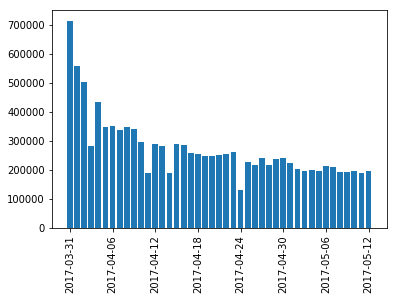

In [102]:
import numpy as np
plt.bar(date_count['date'],date_count['count'])
# the first parameter define the position where to place labels
plt.xticks(np.arange(0, len(date_count['date']),6), rotation='vertical')
plt.show()

# Label definition

In [105]:
import datetime
from dateutil import parser

label_window_size = 14
label_window_end_date = parser.parse('2017-05-12').date()
label_window_start_date = label_window_end_date - datetime.timedelta(label_window_size - 1)
print('label window:',label_window_start_date,'~',label_window_end_date,'days:',label_window_size)

feature_window_size = 29
feature_window_end_date = label_window_start_date - datetime.timedelta(1)
feature_window_start_date = feature_window_end_date  - datetime.timedelta(feature_window_size - 1)
print('feature window:',feature_window_start_date,'~',feature_window_end_date,'days:',feature_window_size)

label window: 2017-04-29 ~ 2017-05-12 days: 14
feature window: 2017-03-31 ~ 2017-04-28 days: 29


In [106]:
# all the uid we will model
df_model_uid = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))\
                    .select('uid').distinct()
# active in label window (active label=0)
df_active_uid_in_label_window = df.filter((F.col('date')>=label_window_start_date) & (F.col('date')<=label_window_end_date))\
                            .select('uid').distinct().withColumn('label',F.lit(0)) # literal column

In [111]:
df_active_uid_in_label_window.show()

+---------+-----+
|      uid|label|
+---------+-----+
|167654524|    0|
|167571223|    0|
|167762949|    0|
|167635050|    0|
|167643276|    0|
|167986370|    0|
|167718831|    0|
|167889975|    0|
|167909036|    0|
|167697660|    0|
|168016318|    0|
|168361537|    0|
|168005091|    0|
|167839954|    0|
|167807923|    0|
|168194683|    0|
|168134101|    0|
|168225678|    0|
|168165209|    0|
|168116641|    0|
+---------+-----+
only showing top 20 rows



In [117]:
# prepare label data (churn label=1; active label=0)
# the uid existing in the feature window but not in the label window is regarded as churned
# the uid existing in the label window but not in the feature window is dropped
df_label = df_model_uid.join(df_active_uid_in_label_window,on=['uid'],how='left')
df_label = df_label.fillna(1)

In [115]:
df_model_uid.count()

46775

In [116]:
df_active_uid_in_label_window.count()

23380

In [118]:
df_label.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|25161|
|    0|21614|
+-----+-----+



# Feature generation

### Frequency features

In [128]:
# define a function to generate frequency features for a list of time windows
# using when().otherwise(), and list comprehension trick!
# when().otherwise() records the number of appearance in spefic time window
# use list comprehension to realize some function, then open the list use *
def frequency_feature_generation_time_windows(df,event,time_window_list,snapshot_date):
    """
    generate frequency features for one event type and a list of time windows
    """
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) & (F.col('date')<=snapshot_date),1).otherwise(0)).alias('freq_'+event+'_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [129]:
# generate one event type, all time windows 
event = 'S'
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date
df_feature = frequency_feature_generation_time_windows(df_feature_window,event,time_window_list,snapshot_date)
df_feature.show(5)

+---------+-------------+-------------+-------------+--------------+--------------+
|      uid|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+
|168361537|            0|            0|            0|             2|            10|
|168036229|            1|            1|            1|             1|            49|
|167902211|            0|            0|            0|             0|             4|
|167839954|            0|            0|            0|             4|             5|
|167960002|            0|            0|            0|             5|            17|
+---------+-------------+-------------+-------------+--------------+--------------+
only showing top 5 rows



In [130]:
# generate frequency features for all event_list, time_window_list
event_list = ['P','D','S']
time_window_list = [1,3,7,14,30]
df_feature_list = []
for event in event_list:
    df_feature_list.append(frequency_feature_generation_time_windows(df_feature_window,event,time_window_list,snapshot_date))


In [131]:
df_feature_list

[DataFrame[uid: string, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint],
 DataFrame[uid: string, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint],
 DataFrame[uid: string, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint]]

### Profile features

In [132]:
df_play = spark.read.csv('../data/play_ds.csv',header=True)
df_play.show(5)

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168047889|    ip|  708741|2017-03-31|      315|        320|
|167704566|    ar| 9902748|2017-03-31|       38|        187|
|167630166|    ar|  795430|2017-03-31|      179|        302|
|167850949|    ar| 6692062|2017-03-31|      146|        146|
|167921394|    ar|23485804|2017-03-31|        0|        229|
+---------+------+--------+----------+---------+-----------+
only showing top 5 rows



In [133]:
df_play_feature_window = df_play.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))
df_profile_tmp = df_play_feature_window.select('uid','device').distinct()


In [134]:
# method 1
df_profile_tmp.groupBy('device').count().show()
# method 2
df_profile_tmp = df_profile_tmp.withColumn('device_type',F.when(F.col('device')=='ip',1).otherwise(2))
df_profile_tmp.groupBy('device_type').count().show()

+------+-----+
|device|count|
+------+-----+
|    ar|40179|
|    ip| 6509|
+------+-----+



In [151]:
df_profile = df_label.select('uid').join(df_profile_tmp.select('uid','device_type'),on='uid',how='left')
df_profile.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|       null|   93|
|          1| 6509|
|          2|40179|
+-----------+-----+



In [137]:
# check if one user has two devices
df_profile_tmp.select('uid').count()

46688

In [138]:
df_profile_tmp.select('uid').distinct().count()

46682

In [146]:
# the uids which have two devices
df_profile_tmp.groupBy('uid').agg(F.count(F.col('uid')).alias('count')).filter(F.col('count')!=1).show()

+---------+-----+
|      uid|count|
+---------+-----+
|168652075|    2|
| 55036072|    2|
|168577107|    2|
| 28342603|    2|
|168166429|    2|
|168165756|    2|
+---------+-----+



### Total play time features

In [ ]:
# Can you generate total song play time features (using play_ds data) for different time window
# using play data (need to clean play time first, play time may be negative in data)


### Fancier frequency features

In [ ]:
# Can you generate counts of songs play 80% of their song length (using play_ds data) for different time window
# using play data (need to clean play time and song length first, play time may be negative in data, song length may be zeros)


# Form training data

In [152]:
def join_feature_data(df_master,df_feature_list):
    for df_feature in df_feature_list:
        df_master = df_master.join(df_feature,on='uid',how='left')
        #df_master.persist() # uncomment if number of joins is too many
    return df_master
    

In [155]:
# join all behavior features
df_model_final = join_feature_data(df_label,df_feature_list)

In [157]:
# join all profile features
df_model_final = join_feature_data(df_model_final,[df_profile])

In [194]:
# need to fillna, since some uids don't appear in the play, search, download file
df_model_final.fillna(0).toPandas().to_csv('../data/df_model_final.csv',index=False)